In [102]:
#it is better to use the ensemble identifiers as gene identifiers rather than the gene names
#mass spec needed proteins so it was more natural to use gene name identifers
#rna seq it was more natual to use ensemble numbers for transcripts

#import libaries
import numpy as np
import pandas as pd
import gzip
import h5py
import openpyxl
import random
import scipy.io
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
from scipy.stats import pearsonr
import openpyxl
import h5py
import pandas as pd
import random
import scipy.io
import json
import requests
import matplotlib.colors as colors
import seaborn as sns
import time
from matplotlib.ticker import MaxNLocator
from IPython.display import display, FileLink, HTML, Markdown
from matplotlib.colors import ListedColormap
from scipy.stats import gaussian_kde
from scipy.stats import zscore


In [103]:
#Find the common genes between the two datasets
#then make two tensors based on that data

# Load the RNA data
file_path = '/home/dwk681/workspace/GSE143519/data/GSE143519_normalized_annotated_counts_all.results.tsv.gz'
with gzip.open(file_path, 'rt') as f:
    rna_df = pd.read_csv(f, sep='\t')

# Extract the gene names from the RNA data
rna_gene_names = rna_df['external_gene_name'].values

#load the mass spec data
excel_file_path = '/home/dwk681/workspace/GSE143519/data/mmc1.xlsx'
sheet_name = 'Table S1 data'

# Reading the specified sheet from the Excel file
mass_spec_data = pd.read_excel(excel_file_path, sheet_name=sheet_name)

# Splitting gene names with semicolons and creating separate rows for each
split_genes = mass_spec_data['Gene names'].str.split(';').explode().reset_index()
split_mass_spec_data = mass_spec_data.loc[split_genes['index']].copy()
split_mass_spec_data['Gene names'] = split_genes.values[:, 1]

# Averaging duplicate rows so that each gene has unique rows
unique_mass_spec_data = split_mass_spec_data.groupby('Gene names').mean().reset_index()

# Get the list of unique genes from the mass spec data
unique_mass_spec_genes = unique_mass_spec_data['Gene names'].values

# Find the common genes between RNA and mass spec data
common_genes = set(rna_gene_names).intersection(set(unique_mass_spec_genes))

# Filter the RNA dataframe to keep only common genes
filtered_rna_df = rna_df[rna_df['external_gene_name'].isin(common_genes)]

# Remove duplicate genes from the filtered RNA dataframe
#MATR3 has two ensemble identifiers, so I am removing the second one
filtered_rna_df = filtered_rna_df.drop_duplicates(subset='external_gene_name', keep='first')

# Extracting relevant columns
# For 0% stress at 30 min, we use one of the WT replicates (e.g., REP_1)
stress_0_30 = filtered_rna_df['S_001-F_KATE-L_____0-___-__WT-REP_1-READ']

# For 0% stress at 360 min, we average the other two WT replicates
stress_0_360 = filtered_rna_df[['S_002-F_KATE-L_____0-___-__WT-REP_2-READ', 'S_003-F_KATE-L_____0-___-__WT-REP_3-READ']].mean(axis=1)

# For 40% stress at 30 min and 360 min, we average the three replicates
stress_40_30 = filtered_rna_df[['S_004-F_KATE-L____40-___-__30-REP_1-READ', 
                   'S_005-F_KATE-L____40-___-__30-REP_2-READ', 
                   'S_006-F_KATE-L____40-___-__30-REP_3-READ']].mean(axis=1)

stress_40_360 = filtered_rna_df[['S_007-F_KATE-L____40-___-_360-REP_1-READ', 
                    'S_008-F_KATE-L____40-___-_360-REP_2-READ', 
                    'S_009-F_KATE-L____40-___-_360-REP_3-READ']].mean(axis=1)

# Combine the vectors into a matrix (DataFrame)
matrix = pd.concat([
    stress_0_30,
    stress_0_360,
    stress_40_30,
    stress_40_360
], axis=1)

# Compute the z-scores for each gene (row-wise)
zscored_matrix = matrix.apply(zscore, axis=1)

# Split the z-scored matrix back into separate vectors
z_stress_0_30 = zscored_matrix.iloc[:, 0]
z_stress_0_360 = zscored_matrix.iloc[:, 1]
z_stress_40_30 = zscored_matrix.iloc[:, 2]
z_stress_40_360 = zscored_matrix.iloc[:, 3]





# Number of genes
num_genes = filtered_rna_df.shape[0]

# Creating the tensor with shape (num_genes, 2 stress levels, 2 timepoints)
expression_tensor = np.zeros((num_genes, 2, 2))

# Filling the tensor
expression_tensor[:, 0, 0] = z_stress_0_30    # 0% stress, 30 min
expression_tensor[:, 0, 1] = z_stress_0_360   # 0% stress, 360 min
expression_tensor[:, 1, 0] = z_stress_40_30   # 40% stress, 30 min
expression_tensor[:, 1, 1] = z_stress_40_360  # 40% stress, 360 min

print(expression_tensor.shape)

# Filter the unique_mass_spec_data to include only common genes
filtered_mass_spec_data = unique_mass_spec_data[unique_mass_spec_data['Gene names'].isin(common_genes)]

# Update the number of unique genes after filtering
num_filtered_genes = filtered_mass_spec_data.shape[0]
unique_mass_spec_tensor = np.zeros((num_filtered_genes, 2, 2))

# Filling the tensor
unique_mass_spec_tensor[:, 0, 0] = filtered_mass_spec_data[['0% #1']].mean(axis=1)
unique_mass_spec_tensor[:, 0, 1] = filtered_mass_spec_data[['0% #2', '0% #3']].mean(axis=1)
unique_mass_spec_tensor[:, 1, 0] = filtered_mass_spec_data[['40% 30m #1', '40% 30m #2', '40% 30m #3']].mean(axis=1)
unique_mass_spec_tensor[:, 1, 1] = filtered_mass_spec_data[['40% 6hr #1', '40% 6hr #2', '40% 6hr #3']].mean(axis=1)

# Update the cluster IDs based on the filtered data
updated_cluster_ids = gene_cluster_df[gene_cluster_df['Gene names'].isin(common_genes)]
updated_cluster_ids = updated_cluster_ids.groupby('Gene names').agg(lambda x: -1 if len(x) > 1 else x.iloc[0])
updated_cluster_ids = updated_cluster_ids.reindex(filtered_mass_spec_data['Gene names']).fillna(-1).astype(int)

# Extracting the updated cluster ID vector
updated_cluster_id_vector = updated_cluster_ids['Cluster ID'].values

print(unique_mass_spec_tensor.shape)
print(len(updated_cluster_id_vector))

# Find the minimum value in each tensor
min_value_expression = np.min(expression_tensor)
min_value_mass_spec = np.min(unique_mass_spec_tensor)

# If the minimum value is negative, add its absolute value to the tensor
if min_value_expression < 0:
    expression_tensor += abs(min_value_expression)

if min_value_mass_spec < 0:
    unique_mass_spec_tensor += abs(min_value_mass_spec)

# Check the new minimum values to ensure tensors are non-negative
new_min_value_expression = np.min(expression_tensor)
new_min_value_mass_spec = np.min(unique_mass_spec_tensor)

# Print the original and new minimum values
print("Original Min in Expression Tensor:", min_value_expression)
print("New Min in Expression Tensor:", new_min_value_expression)
print("Original Min in Mass Spec Tensor:", min_value_mass_spec)
print("New Min in Mass Spec Tensor:", new_min_value_mass_spec)

big_tensor = np.zeros((len(common_genes), 2, 2, 2))

# Populate the big tensor
# For n4 = 0, use RNA tensor values
big_tensor[:, :, :, 0] =  expression_tensor

# For n4 = 1, use Mass Spec tensor values
big_tensor[:, :, :, 1] = unique_mass_spec_tensor

# Check the shape of the big tensor
print("Shape of the big tensor:", big_tensor.shape)

common_genes_list = list(common_genes)

#saving the tensor
# File path for saving the .h5 file
h5_file_path = '/home/dwk681/workspace/GSE143519/data/RNA_massSpec_data_823_2_2_2_tensor.h5'

# Creating and saving the .h5 file
with h5py.File(h5_file_path, 'w') as h5f:
    # Saving the tensor
    h5f.create_dataset('tensor', data=big_tensor)
    # Saving the gene names as a dataset of strings requires special handling
    dt = h5py.special_dtype(vlen=str)
    h5f.create_dataset('gene_names', data=common_genes_list, dtype=dt)
    #saving the cluster IDs
    h5f.create_dataset('cluster_ids', data=updated_cluster_id_vector)
    


/tmp/ipykernel_23203/359189858.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  unique_mass_spec_data = split_mass_spec_data.groupby('Gene names').mean().reset_index()


(823, 2, 2)
(823, 2, 2)
823
Original Min in Expression Tensor: -1.7313127003053403
New Min in Expression Tensor: 0.0
Original Min in Mass Spec Tensor: -2.2457
New Min in Mass Spec Tensor: 0.0
Shape of the big tensor: (823, 2, 2, 2)


In [106]:
# Load the MAT file
mat_data = scipy.io.loadmat('/home/dwk681/workspace/GSE143519/Workspaces/translated_structuredData_massSpec_RNA_first10_800iterations_zscores.mat')
sol_factors = mat_data['sol_factors']

In [107]:
r = 2

feature_factor1 = sol_factors[0][2][0][3][:,1]
feature_factor2 = sol_factors[0][2][0][3][:,2]

correlation, p_value = pearsonr(feature_factor1, feature_factor2)

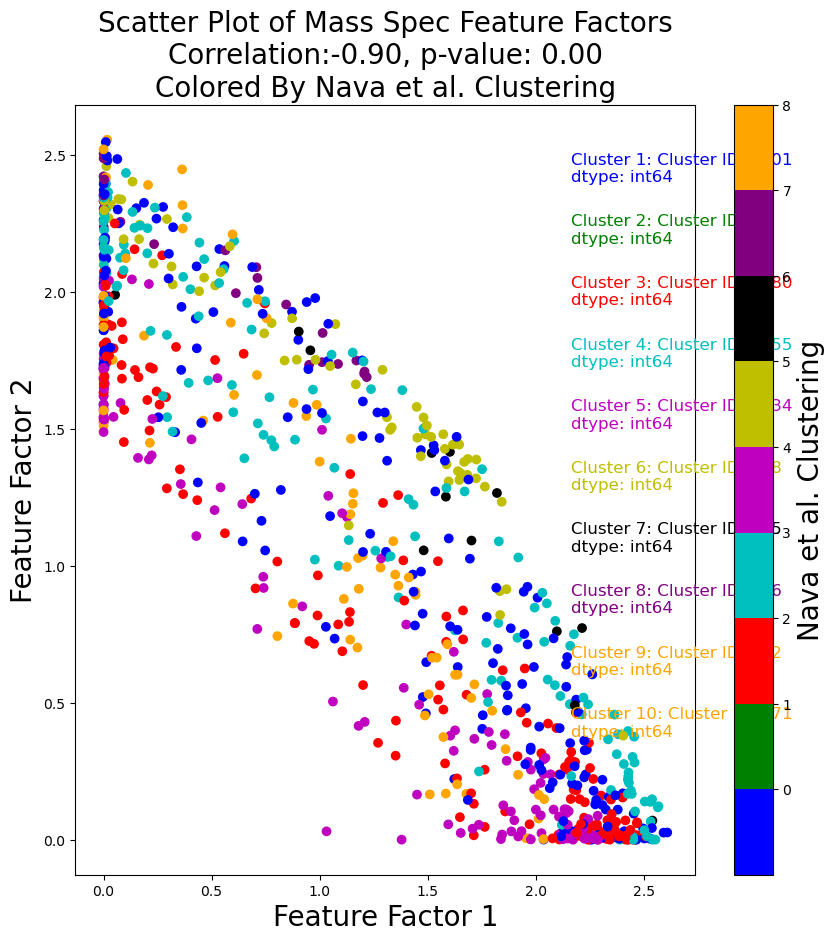

In [108]:
# Define a threshold for outliers (e.g., 3 standard deviations)
std_dev_threshold = 3
mean1, std1 = np.mean(feature_factor1), np.std(feature_factor1)
mean2, std2 = np.mean(feature_factor2), np.std(feature_factor2)

# Mask for values within +/− 3 standard deviations
mask = np.abs(feature_factor1 - mean1) < std_dev_threshold * std1
mask &= np.abs(feature_factor2 - mean2) < std_dev_threshold * std2

# Filter data to remove outliers
filtered_factor1 = feature_factor1[mask]
filtered_factor2 = feature_factor2[mask]
filtered_clusters = updated_cluster_id_vector[mask]

# Create the scatter plot with the filtered data
fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))
correlation, p_value = pearsonr(filtered_factor1, filtered_factor2)
cluster_colors = ListedColormap(['b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple', 'orange'])
scatter = ax1.scatter(filtered_factor1, filtered_factor2, c=filtered_clusters, cmap=cluster_colors)
ax1.set_title(f'Scatter Plot of Mass Spec Feature Factors\nCorrelation:{correlation:.2f}, p-value: {p_value:.2f}\nColored By Nava et al. Clustering', fontsize=20)
cbar = plt.colorbar(scatter, ax=ax1, ticks=range(9))
cbar.set_label('Nava et al. Clustering', fontsize=20)

# Calculate the size of each cluster
cluster_sizes = [np.sum(cluster_ids == i) for i in range(-1,9)]  

# Display the size of each cluster
for i, size in enumerate(cluster_sizes):
    ax1.text(0.8, 0.9 - i * 0.08, f'Cluster {i+1}: {size}', transform=ax1.transAxes, fontsize=12, color=cluster_colors(i))

ax1.set_xlabel('Feature Factor 1', fontsize=20)
ax1.set_ylabel('Feature Factor 2', fontsize=20)

plt.show()

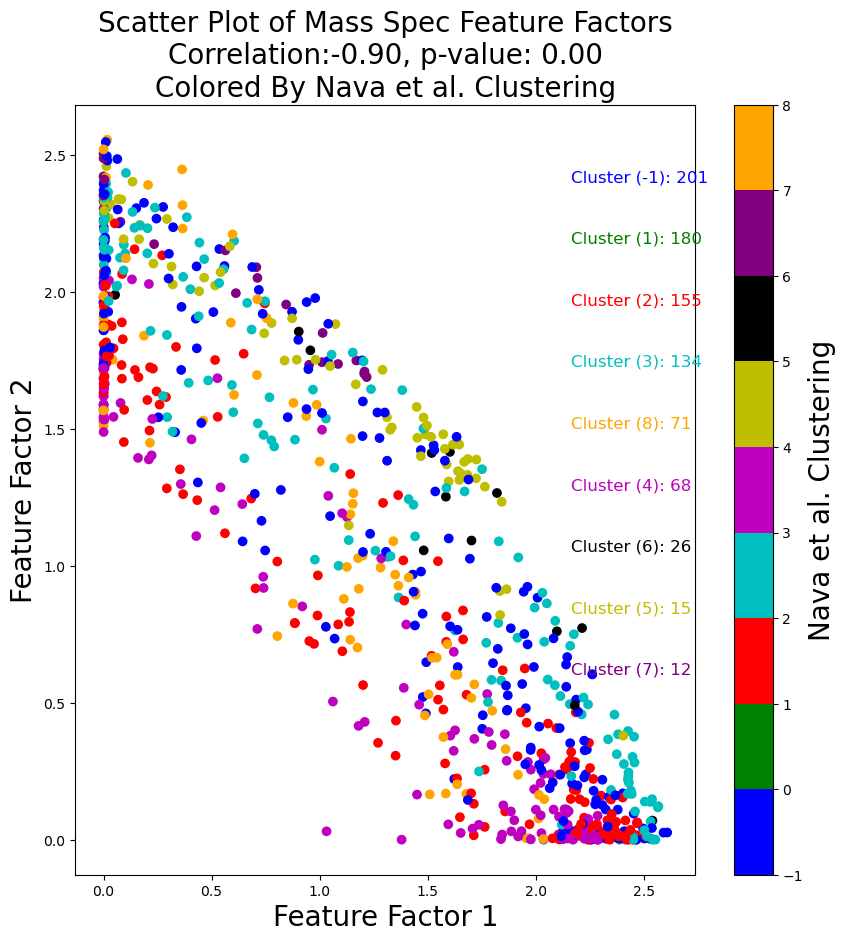

In [119]:
mat_data = scipy.io.loadmat('/home/dwk681/workspace/GSE143519/Workspaces/translated_structuredData_massSpec_RNA_first10_800iterations_zscores.mat')
sol_factors = mat_data['sol_factors']

# Create the scatter plot with the filtered data
fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))
correlation, p_value = pearsonr(feature_factor1, feature_factor2)
cluster_colors = ListedColormap(['b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple', 'orange'])
scatter = ax1.scatter(feature_factor1, feature_factor2, c=filtered_clusters, cmap=cluster_colors)
ax1.set_title(f'Scatter Plot of Mass Spec Feature Factors\nCorrelation:{correlation:.2f}, p-value: {p_value:.2f}\nColored By Nava et al. Clustering', fontsize=20)
cbar = plt.colorbar(scatter, ax=ax1, ticks=range(-1,9))
cbar.set_label('Nava et al. Clustering', fontsize=20)


cluster_sizes = cluster_ids.value_counts().to_dict()

# Create a dictionary to map cluster ID to the index used in cluster_colors
color_index_map = {id: index for index, id in enumerate(sorted(cluster_sizes.keys()))}

# Initialize a variable for the y-offset of the cluster size text
text_y_offset = 0.9

# Adjust the label text to reflect the cluster sizes
for i, size in cluster_sizes.items():
    label_text = f'Cluster {i}: {size}' if i != -1 else f'Noise: {size}'

    # Remove the comma by formatting the number as a string
    label_text = label_text.replace(',', '')    
    # Get the color index from the map
    color_index = color_index_map[i]
    
    # Look up the color using the color index
    color = cluster_colors.colors[color_index]
    
    # Place the text on the plot
    ax1.text(0.8, text_y_offset, label_text, transform=ax1.transAxes, fontsize=12, color=color)
    
    # Update the y-offset for the next label
    text_y_offset -= 0.08
# Calculate the size of each cluster
#cluster_sizes = [np.sum(cluster_ids == i) for i in range(-1,9)]  

# Display the size of each cluster
#for i, size in enumerate(cluster_sizes):
#    ax1.text(0.8, 0.9 - i * 0.08, f'Cluster {i+1}: {size}', transform=ax1.transAxes, fontsize=12, color=cluster_colors(i))

ax1.set_xlabel('Feature Factor 1', fontsize=20)
ax1.set_ylabel('Feature Factor 2', fontsize=20)

plt.show()

In [115]:
np.sum(cluster_ids ==-1)

Cluster ID    201
dtype: int64

In [ ]:
#old files that I used for practice

In [18]:
#import RNA data and organize as a three fold tensor
# File path
file_path = '/home/dwk681/workspace/GSE143519/data/GSE143519_normalized_annotated_counts_all.results.tsv.gz'
# Reading the file
with gzip.open(file_path, 'rt') as f:
    # Read only the first few lines to get an overview of the file content
    df = pd.read_csv(f, sep='\t')
#df.head()

# Extracting relevant columns
# For 0% stress at 30 min, we use one of the WT replicates (e.g., REP_1)
stress_0_30 = df['S_001-F_KATE-L_____0-___-__WT-REP_1-READ']

# For 0% stress at 360 min, we average the other two WT replicates
stress_0_360 = df[['S_002-F_KATE-L_____0-___-__WT-REP_2-READ', 'S_003-F_KATE-L_____0-___-__WT-REP_3-READ']].mean(axis=1)

# For 40% stress at 30 min and 360 min, we average the three replicates
stress_40_30 = df[['S_004-F_KATE-L____40-___-__30-REP_1-READ', 
                   'S_005-F_KATE-L____40-___-__30-REP_2-READ', 
                   'S_006-F_KATE-L____40-___-__30-REP_3-READ']].mean(axis=1)

stress_40_360 = df[['S_007-F_KATE-L____40-___-_360-REP_1-READ', 
                    'S_008-F_KATE-L____40-___-_360-REP_2-READ', 
                    'S_009-F_KATE-L____40-___-_360-REP_3-READ']].mean(axis=1)

# Number of genes
num_genes = df.shape[0]

# Creating the tensor with shape (num_genes, 2 stress levels, 2 timepoints)
expression_tensor = np.zeros((num_genes, 2, 2))

# Filling the tensor
expression_tensor[:, 0, 0] = stress_0_30    # 0% stress, 30 min
expression_tensor[:, 0, 1] = stress_0_360   # 0% stress, 360 min
expression_tensor[:, 1, 0] = stress_40_30   # 40% stress, 30 min
expression_tensor[:, 1, 1] = stress_40_360  # 40% stress, 360 min

print(expression_tensor.shape)

# Extracting the vector of gene names
gene_names = df['external_gene_name'].values
#gene_names[:10]  # Displaying the first 10 gene names as an example

(23085, 2, 2)


In [37]:
#import the mass spec data and also save as a tensor
#The problem is that the original data had duplicates, that is multiple rows corresponding to the same gene
#or one row corresponding to two different genes. These duplicates were sometimes assigned to different clusters.
#If the duplicates were assigned to different clusters, I have assigned them the value of -1 here

# Input Excel file and output HDF5 file paths
excel_file_path = '/home/dwk681/workspace/GSE143519/data/mmc1.xlsx'
sheet_name = 'Table S1 data'

# Reading the specified sheet from the Excel file
mass_spec_data = pd.read_excel(excel_file_path, sheet_name=sheet_name)

# Splitting gene names with semicolons and creating separate rows for each
split_genes = mass_spec_data['Gene names'].str.split(';').explode().reset_index()
split_mass_spec_data = mass_spec_data.loc[split_genes['index']].copy()
split_mass_spec_data['Gene names'] = split_genes.values[:, 1]

# Averaging duplicate rows so that each gene has unique rows
unique_mass_spec_data = split_mass_spec_data.groupby('Gene names').mean().reset_index()

# Creating the tensor from the unique data
num_unique_genes = unique_mass_spec_data.shape[0]
unique_mass_spec_tensor = np.zeros((num_unique_genes, 2, 2))

# Filling the tensor
unique_mass_spec_tensor[:, 0, 0] = unique_mass_spec_data[['0% #1']].mean(axis=1)
unique_mass_spec_tensor[:, 0, 1] = unique_mass_spec_data[['0% #2', '0% #3']].mean(axis=1)
unique_mass_spec_tensor[:, 1, 0] = unique_mass_spec_data[['40% 30m #1', '40% 30m #2', '40% 30m #3']].mean(axis=1)
unique_mass_spec_tensor[:, 1, 1] = unique_mass_spec_data[['40% 6hr #1', '40% 6hr #2', '40% 6hr #3']].mean(axis=1)

# Creating a DataFrame with gene names, cluster IDs, and checking for duplicates with different cluster IDs
split_mass_spec_data['Cluster ID'] = split_mass_spec_data['Cluster name'].str.extract('(\d+)').astype(int)
gene_cluster_df = split_mass_spec_data[['Gene names', 'Cluster ID']].drop_duplicates()

# Assigning a cluster ID of -1 to genes with different cluster IDs in the original data
cluster_ids = gene_cluster_df.groupby('Gene names').agg(lambda x: -1 if len(x) > 1 else x.iloc[0])
cluster_ids = cluster_ids.reindex(unique_mass_spec_data['Gene names']).fillna(-1).astype(int)

# Extracting the cluster ID vector
cluster_id_vector = cluster_ids['Cluster ID'].values

# Displaying the shape of the tensor and the first 5 entries of the cluster ID vector
unique_mass_spec_tensor.shape, cluster_id_vector[:5]


/tmp/ipykernel_23203/4018118839.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  unique_mass_spec_data = split_mass_spec_data.groupby('Gene names').mean().reset_index()


((862, 2, 2), array([ 3,  2,  2,  6, -1]))

In [41]:
'''
# Load the RNA data
file_path = '/home/dwk681/workspace/GSE143519/data/GSE143519_normalized_annotated_counts_all.results.tsv.gz'
with gzip.open(file_path, 'rt') as f:
    rna_df = pd.read_csv(f, sep='\t')

# Extract the gene names from the RNA data
rna_gene_names = rna_df['external_gene_name'].values

# Get the list of unique genes from the mass spec data
unique_mass_spec_genes = unique_mass_spec_data['Gene names'].values

# Convert to sets for efficient computation
unique_mass_spec_genes_set = set(unique_mass_spec_genes)
unique_rna_genes_set = set(rna_gene_names)

# Finding genes present in mass spec data but not in RNA data
genes_in_mass_spec_not_in_rna = unique_mass_spec_genes_set - unique_rna_genes_set

# Displaying the results
len(genes_in_mass_spec_not_in_rna), genes_in_mass_spec_not_in_rna
'''


"\n# Load the RNA data\nfile_path = '/home/dwk681/workspace/GSE143519/data/GSE143519_normalized_annotated_counts_all.results.tsv.gz'\nwith gzip.open(file_path, 'rt') as f:\n    rna_df = pd.read_csv(f, sep='\t')\n\n# Extract the gene names from the RNA data\nrna_gene_names = rna_df['external_gene_name'].values\n\n# Get the list of unique genes from the mass spec data\nunique_mass_spec_genes = unique_mass_spec_data['Gene names'].values\n\n# Convert to sets for efficient computation\nunique_mass_spec_genes_set = set(unique_mass_spec_genes)\nunique_rna_genes_set = set(rna_gene_names)\n\n# Finding genes present in mass spec data but not in RNA data\ngenes_in_mass_spec_not_in_rna = unique_mass_spec_genes_set - unique_rna_genes_set\n\n# Displaying the results\nlen(genes_in_mass_spec_not_in_rna), genes_in_mass_spec_not_in_rna\n"

In [57]:
#Find the common genes between the two datasets
#then make two tensors based on that data

# Load the RNA data
file_path = '/home/dwk681/workspace/GSE143519/data/GSE143519_normalized_annotated_counts_all.results.tsv.gz'
with gzip.open(file_path, 'rt') as f:
    rna_df = pd.read_csv(f, sep='\t')

# Extract the gene names from the RNA data
rna_gene_names = rna_df['external_gene_name'].values

#load the mass spec data
excel_file_path = '/home/dwk681/workspace/GSE143519/data/mmc1.xlsx'
sheet_name = 'Table S1 data'

# Reading the specified sheet from the Excel file
mass_spec_data = pd.read_excel(excel_file_path, sheet_name=sheet_name)

# Splitting gene names with semicolons and creating separate rows for each
split_genes = mass_spec_data['Gene names'].str.split(';').explode().reset_index()
split_mass_spec_data = mass_spec_data.loc[split_genes['index']].copy()
split_mass_spec_data['Gene names'] = split_genes.values[:, 1]

# Averaging duplicate rows so that each gene has unique rows
unique_mass_spec_data = split_mass_spec_data.groupby('Gene names').mean().reset_index()

# Get the list of unique genes from the mass spec data
unique_mass_spec_genes = unique_mass_spec_data['Gene names'].values

# Find the common genes between RNA and mass spec data
common_genes = set(rna_gene_names).intersection(set(unique_mass_spec_genes))

# Filter the RNA dataframe to keep only common genes
filtered_rna_df = rna_df[rna_df['external_gene_name'].isin(common_genes)]

# Remove duplicate genes from the filtered RNA dataframe
#MATR3 has two ensemble identifiers, so I am removing the second one
filtered_rna_df = filtered_rna_df.drop_duplicates(subset='external_gene_name', keep='first')

# Extracting relevant columns
# For 0% stress at 30 min, we use one of the WT replicates (e.g., REP_1)
stress_0_30 = filtered_rna_df['S_001-F_KATE-L_____0-___-__WT-REP_1-READ']

# For 0% stress at 360 min, we average the other two WT replicates
stress_0_360 = filtered_rna_df[['S_002-F_KATE-L_____0-___-__WT-REP_2-READ', 'S_003-F_KATE-L_____0-___-__WT-REP_3-READ']].mean(axis=1)

# For 40% stress at 30 min and 360 min, we average the three replicates
stress_40_30 = filtered_rna_df[['S_004-F_KATE-L____40-___-__30-REP_1-READ', 
                   'S_005-F_KATE-L____40-___-__30-REP_2-READ', 
                   'S_006-F_KATE-L____40-___-__30-REP_3-READ']].mean(axis=1)

stress_40_360 = filtered_rna_df[['S_007-F_KATE-L____40-___-_360-REP_1-READ', 
                    'S_008-F_KATE-L____40-___-_360-REP_2-READ', 
                    'S_009-F_KATE-L____40-___-_360-REP_3-READ']].mean(axis=1)

# Number of genes
num_genes = filtered_rna_df.shape[0]

# Creating the tensor with shape (num_genes, 2 stress levels, 2 timepoints)
expression_tensor = np.zeros((num_genes, 2, 2))

# Filling the tensor
expression_tensor[:, 0, 0] = stress_0_30    # 0% stress, 30 min
expression_tensor[:, 0, 1] = stress_0_360   # 0% stress, 360 min
expression_tensor[:, 1, 0] = stress_40_30   # 40% stress, 30 min
expression_tensor[:, 1, 1] = stress_40_360  # 40% stress, 360 min

print(expression_tensor.shape)


# Filter the unique_mass_spec_data to include only common genes
filtered_mass_spec_data = unique_mass_spec_data[unique_mass_spec_data['Gene names'].isin(common_genes)]

# Update the number of unique genes after filtering
num_filtered_genes = filtered_mass_spec_data.shape[0]
unique_mass_spec_tensor = np.zeros((num_filtered_genes, 2, 2))

# Filling the tensor
unique_mass_spec_tensor[:, 0, 0] = filtered_mass_spec_data[['0% #1']].mean(axis=1)
unique_mass_spec_tensor[:, 0, 1] = filtered_mass_spec_data[['0% #2', '0% #3']].mean(axis=1)
unique_mass_spec_tensor[:, 1, 0] = filtered_mass_spec_data[['40% 30m #1', '40% 30m #2', '40% 30m #3']].mean(axis=1)
unique_mass_spec_tensor[:, 1, 1] = filtered_mass_spec_data[['40% 6hr #1', '40% 6hr #2', '40% 6hr #3']].mean(axis=1)



# Update the cluster IDs based on the filtered data
updated_cluster_ids = gene_cluster_df[gene_cluster_df['Gene names'].isin(common_genes)]
updated_cluster_ids = updated_cluster_ids.groupby('Gene names').agg(lambda x: -1 if len(x) > 1 else x.iloc[0])
updated_cluster_ids = updated_cluster_ids.reindex(filtered_mass_spec_data['Gene names']).fillna(-1).astype(int)

# Extracting the updated cluster ID vector
updated_cluster_id_vector = updated_cluster_ids['Cluster ID'].values

print(unique_mass_spec_tensor.shape)
print(len(updated_cluster_id_vector))

(823, 2, 2)
(823, 2, 2)
823


/tmp/ipykernel_23203/2193495465.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  unique_mass_spec_data = split_mass_spec_data.groupby('Gene names').mean().reset_index()


In [50]:
# Check if the filtered gene lists are identical
filtered_rna_genes = set(filtered_rna_df['external_gene_name'].unique())
filtered_mass_spec_genes = set(filtered_mass_spec_data['Gene names'].unique())

# Find genes that are in one filtered set but not the other
genes_in_rna_not_in_mass_spec = filtered_rna_genes - filtered_mass_spec_genes
genes_in_mass_spec_not_in_rna = filtered_mass_spec_genes - filtered_rna_genes

# Display the discrepancies
print("Genes in RNA data but not in Mass Spec data:", len(genes_in_rna_not_in_mass_spec))
print("Genes in Mass Spec data but not in RNA data:", len(genes_in_mass_spec_not_in_rna))

# Display some sample genes from each discrepancy set
print("Sample genes in RNA not in Mass Spec:", list(genes_in_rna_not_in_mass_spec)[:10])
print("Sample genes in Mass Spec not in RNA:", list(genes_in_mass_spec_not_in_rna)[:10])


Genes in RNA data but not in Mass Spec data: 0
Genes in Mass Spec data but not in RNA data: 0
Sample genes in RNA not in Mass Spec: []
Sample genes in Mass Spec not in RNA: []


In [53]:
filtered_mass_spec_data

,Gene names,0% #1,0% #2,0% #3,40% 30m #1,40% 30m #2,40% 30m #3,40% 6hr #1,40% 6hr #2,40% 6hr #3,minus Log p val
0,AAK1,0.733236,0.994561,1.100880,-0.939985,-1.240370,-0.511285,-1.148730,1.116760,-0.105065,1.316870
1,ABCF1,-0.570729,-0.158943,-0.439553,-0.661293,-0.944460,-0.931121,1.087010,0.987461,1.631633,3.136073
2,ABI1,0.339278,-0.981029,-0.347722,-0.834680,-1.130820,-0.534148,0.697879,1.676920,1.114320,2.152710
3,ABLIM1,-0.822041,-0.284421,-0.647035,1.186800,1.496800,1.198050,-0.512680,-0.513833,-1.101640,3.770040
4,ABLIM3,-0.196831,-0.305751,-0.231835,-0.493891,-1.079041,-0.956698,0.984156,1.010728,1.269166,2.651135
...,...,...,...,...,...,...,...,...,...,...,...
856,ZNF609,0.376459,0.316052,0.810636,-0.206185,-1.162301,-1.379149,0.274511,0.480368,0.489612,1.990612
857,ZNF644,1.650290,-0.273218,0.389791,-1.080400,-1.492160,-0.783442,0.191744,0.819569,0.577826,1.588690
858,ZNF800,-0.419063,0.822599,-0.243040,-0.571802,-1.058868,-1.367195,0.368158,1.451040,1.018174,1.628635
859,ZNRF2,0.236745,0.942934,1.781470,-0.554957,-0.604846,0.761017,-1.027400,-0.323273,-1.211690,1.351320


In [54]:
# Displaying the first row of the filtered RNA dataframe
first_row_rna = filtered_rna_df.head(1)
print("First row of the RNA dataframe:")
print(first_row_rna)

# Displaying the first row of the filtered Mass Spec dataframe
first_row_mass_spec = filtered_mass_spec_data.head(1)
print("\nFirst row of the Mass Spec dataframe:")
print(first_row_mass_spec)

First row of the RNA dataframe:
    ensembl_gene_id external_gene_name  \
25  ENSG00000002834              LASP1   

    S_001-F_KATE-L_____0-___-__WT-REP_1-READ  \
25                               6080.803638   

    S_002-F_KATE-L_____0-___-__WT-REP_2-READ  \
25                               5126.329145   

    S_003-F_KATE-L_____0-___-__WT-REP_3-READ  \
25                               5339.919895   

    S_004-F_KATE-L____40-___-__30-REP_1-READ  \
25                               5503.456093   

    S_005-F_KATE-L____40-___-__30-REP_2-READ  \
25                               5626.187205   

    S_006-F_KATE-L____40-___-__30-REP_3-READ  \
25                               5731.407442   

    S_007-F_KATE-L____40-___-_360-REP_1-READ  \
25                               6008.346058   

    S_008-F_KATE-L____40-___-_360-REP_2-READ  ...  stat.S_0_0_vs_S_40_360  \
25                               5799.491543  ...               -1.736681   

    pvalue.S_0_0_vs_S_40_360  padj.S_0_0_vs_S_40_

In [55]:
# Checking for duplicate gene names in the filtered dataframes
duplicate_genes_rna = filtered_rna_df['external_gene_name'].duplicated().sum()
duplicate_genes_mass_spec = filtered_mass_spec_data['Gene names'].duplicated().sum()

print("Duplicate genes in filtered RNA data:", duplicate_genes_rna)
print("Duplicate genes in filtered Mass Spec data:", duplicate_genes_mass_spec)


Duplicate genes in filtered RNA data: 1
Duplicate genes in filtered Mass Spec data: 0


In [56]:
# Identifying the duplicate gene in the filtered RNA data
duplicate_genes_rna = filtered_rna_df[filtered_rna_df['external_gene_name'].duplicated(keep=False)]

# Display the duplicate genes
print(duplicate_genes_rna)


       ensembl_gene_id external_gene_name  \
315    ENSG00000015479              MATR3   
22559  ENSG00000280987              MATR3   

       S_001-F_KATE-L_____0-___-__WT-REP_1-READ  \
315                                 7975.238090   
22559                                957.829545   

       S_002-F_KATE-L_____0-___-__WT-REP_2-READ  \
315                                 7862.954370   
22559                               1097.682804   

       S_003-F_KATE-L_____0-___-__WT-REP_3-READ  \
315                                 8333.342594   
22559                                893.596952   

       S_004-F_KATE-L____40-___-__30-REP_1-READ  \
315                                 9608.991880   
22559                                980.814087   

       S_005-F_KATE-L____40-___-__30-REP_2-READ  \
315                                 8704.793062   
22559                                722.386151   

       S_006-F_KATE-L____40-___-__30-REP_3-READ  \
315                                 8332.35

In [ ]:
# Now, create the RNA tensor as before, but using the filtered RNA dataframe
# ... [Modify your previous RNA tensor creation code to use `filtered_rna_df`] ...

# Note: Ensure that the order of genes in both tensors (RNA and Mass Spec) is the same

# Extract the gene names from the RNA data
rna_gene_names = rna_df['external_gene_name'].values

# Load the mass spec data
excel_file_path = '/home/dwk681/workspace/GSE143519/data/mmc1.xlsx'
sheet_name = 'Table S1 data'
mass_spec_data = pd.read_excel(excel_file_path, sheet_name=sheet_name)

# Process the mass spec data as before to get the unique gene names
# ... [Your previous code for processing the mass spec data] ...

# Get the list of unique genes from the mass spec data
unique_mass_spec_genes = unique_mass_spec_data['Gene names'].values

# Find the common genes between RNA and mass spec data
common_genes = set(rna_gene_names).intersection(set(unique_mass_spec_genes))

# Filter the RNA dataframe to keep only common genes
filtered_rna_df = rna_df[rna_df['external_gene_name'].isin(common_genes)]

# Now, create the RNA tensor as before, but using the filtered RNA dataframe
# ... [Modify your previous RNA tensor creation code to use `filtered_rna_df`] ...

# Note: Ensure that the order of genes in both tensors (RNA and Mass Spec) is the same

In [ ]:
#saving the tensor
# File path for saving the .h5 file
h5_file_path = '/home/dwk681/workspace/GSE143519/data/gene_expression_data.h5'

# Creating and saving the .h5 file
with h5py.File(h5_file_path, 'w') as h5f:
    # Saving the tensor
    h5f.create_dataset('expression_tensor', data=expression_tensor)
    # Saving the gene names as a dataset of strings requires special handling
    dt = h5py.special_dtype(vlen=str)
    h5f.create_dataset('gene_names', data=gene_names, dtype=dt)
